# Loading dataset

Number of images in each class:
AnnualCrop: 2998
Forest: 2998
HerbaceousVegetation: 2997
Highway: 2499
Industrial: 2498
Pasture: 1998
PermanentCrop: 2498
Residential: 2998
River: 2498
SeaLake: 2998


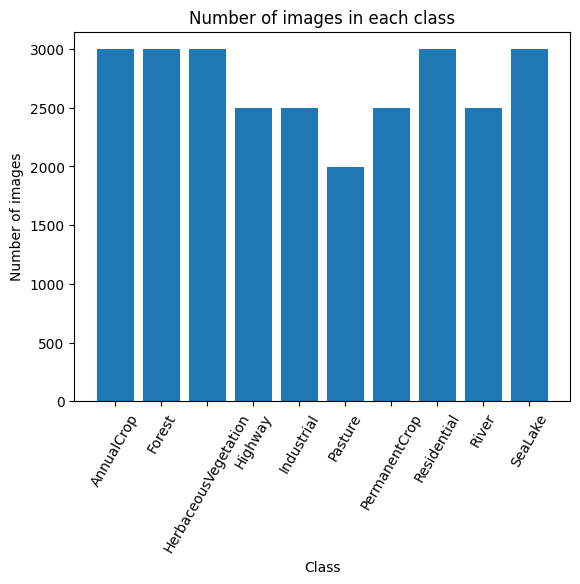

In [424]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your dataset directory
data_dir = '2750/'

# Get a list of class names
class_names = sorted(os.listdir(data_dir))

# Remove hidden files
elements_to_remove = ['.DS_Store']
class_names = [x for x in class_names if x not in elements_to_remove]

# Initialize a dictionary to store the number of images in each class
num_images = {}

# Loop through each class directory
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    num_images[class_name] = len(os.listdir(class_dir))

# Print the number of images in each class
print('Number of images in each class:')
for class_name in class_names:
    print('{}: {}'.format(class_name, num_images[class_name]))

# Plot a bar chart of the number of images in each class
plt.bar(class_names, list(num_images.values()))
plt.title('Number of images in each class')
plt.xlabel('Class')
plt.xticks(rotation=60)
plt.ylabel('Number of images')
plt.show()



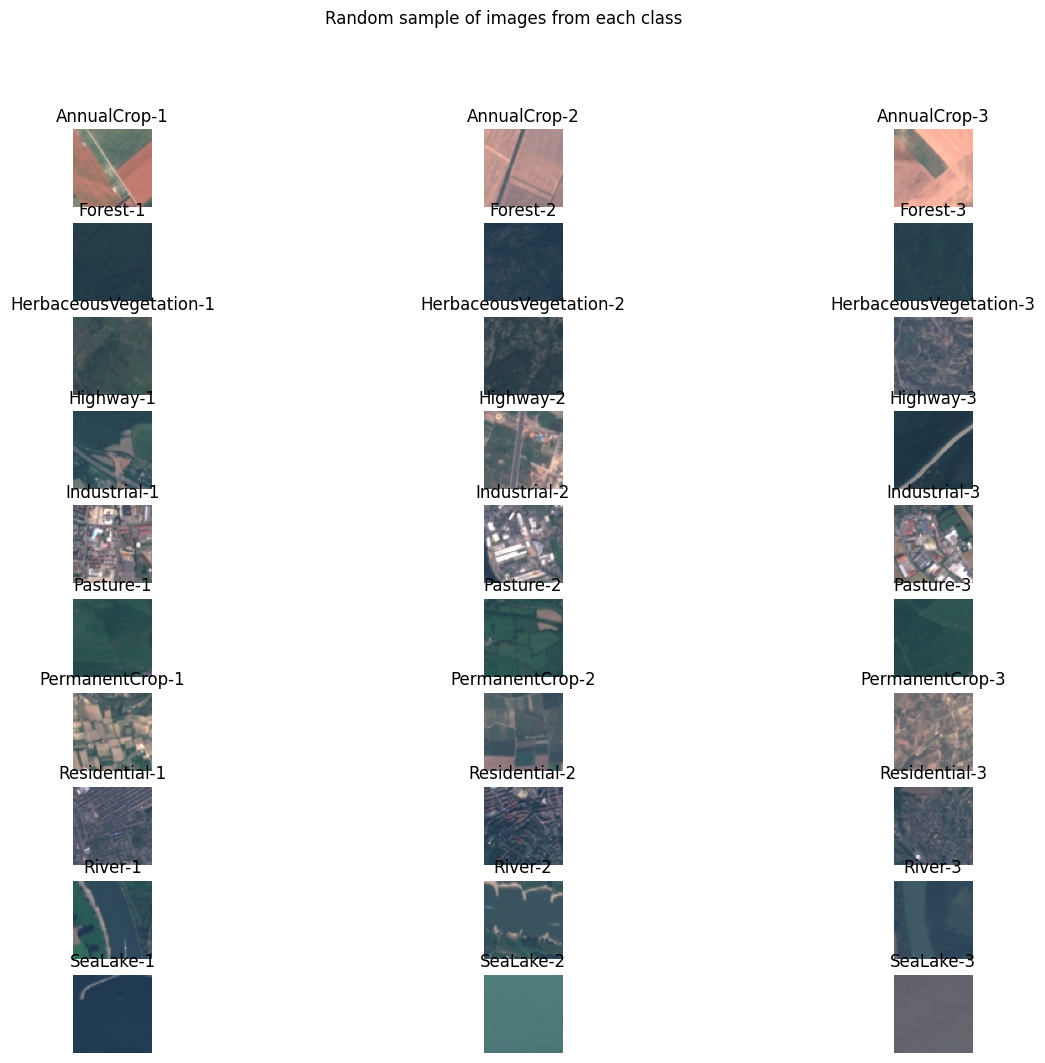

In [239]:
# Visualize a random sample of images from each class
num_samples = 3
fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 12))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    image_filenames = os.listdir(class_dir)
    # Select a random sample of images from the class
    image_filenames = np.random.choice(image_filenames, size=num_samples, replace=False)
    # Plot the images
    for j, image_filename in enumerate(image_filenames):
        image_path = os.path.join(class_dir, image_filename)
        image = plt.imread(image_path)
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title('{}-{}'.format(class_name, j+1))
plt.suptitle('Random sample of images from each class')
plt.show()


# Selecting 20 images for inference

In [422]:
import os
import random
import shutil

# Path to the directory containing the folders with images
data_dir = '2750/'

# Path to the directory where the selected images will be saved
selected_dir = 'inference/test_data/'

# Create the target directory if it doesn't exist
if not os.path.exists(selected_dir):
    os.makedirs(selected_dir)

# Number of images to select from each folder
num_images = 2

# Loop through the folders in the data directory
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    # Check if the current path is a directory
    if os.path.isdir(folder_path):
        image_files = os.listdir(folder_path)
        selected_images = random.sample(image_files, num_images)
        # Loop through the selected images and copy them to the selected directory
        for image in selected_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(selected_dir, image)
            shutil.copy(src, dst)
            # Remove the file from the original location so that model does not see it while training
            os.remove(src)


# Splitting data into train and val

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
from sklearn.model_selection import train_test_split


In [425]:
# Define dataset directory path
data_dir = "2750/"

# Define batch size and image size
batch_size = 32
img_height = 64
img_width = 64

# Use ImageDataGenerator to rescale images and split into train and validation sets
train_ds = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load images from directory using flow_from_directory method of ImageDataGenerator
train_data = train_ds.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training'
)

val_data = train_ds.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

# Get class names from directory names
class_names = train_data.class_indices


Found 21590 images belonging to 10 classes.
Found 5390 images belonging to 10 classes.


# Model architecture

## 1. Shallow CNN Architecture 


In [433]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# Define input shape
input_shape = (64, 64, 3)

# Define the model architecture
model_shallow = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),


    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.05),
    layers.Dense(len(class_names), activation='softmax')

])



model_shallow.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(0.00001),
    metrics=['accuracy'],
)
# Print the model summary
model_shallow.summary()


Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_271 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_181 (MaxPooli  (None, 32, 32, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_272 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_182 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_273 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 8, 8, 64)       

## 2. VGG Architecture

In [414]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

input_shape = (64, 64, 3)

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(0.00005),
    metrics=['accuracy'],
)

model.summary()


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_251 (Conv2D)         (None, 64, 64, 64)        1792      
                                                                 
 conv2d_252 (Conv2D)         (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_169 (MaxPooli  (None, 32, 32, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_253 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 conv2d_254 (Conv2D)         (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_170 (MaxPooli  (None, 16, 16, 128)      0         
 ng2D)                                               

# Model training

### Training Shallow CNN

In [434]:
# Training the shallow model with 3 layers

epochs = 20

# Train the model
history_shallow = model_shallow.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    verbose=1
)

Epoch 1/20


2023-03-18 02:21:52.016178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


673/675 [============================>.] - ETA: 0s - loss: 2.1849 - accuracy: 0.1822

2023-03-18 02:22:05.418585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


675/675 [==============================] - 16s 21ms/step - loss: 2.1842 - accuracy: 0.1829 - val_loss: 2.0032 - val_accuracy: 0.3440
Epoch 2/20
675/675 [==============================] - 14s 20ms/step - loss: 1.8064 - accuracy: 0.3534 - val_loss: 1.6583 - val_accuracy: 0.4067
Epoch 3/20
675/675 [==============================] - 14s 21ms/step - loss: 1.5760 - accuracy: 0.4576 - val_loss: 1.5118 - val_accuracy: 0.4703
Epoch 4/20
675/675 [==============================] - 13s 19ms/step - loss: 1.4586 - accuracy: 0.4986 - val_loss: 1.4162 - val_accuracy: 0.5308
Epoch 5/20
675/675 [==============================] - 14s 21ms/step - loss: 1.3812 - accuracy: 0.5251 - val_loss: 1.3511 - val_accuracy: 0.5351
Epoch 6/20
675/675 [==============================] - 14s 21ms/step - loss: 1.3238 - accuracy: 0.5449 - val_loss: 1.3019 - val_accuracy: 0.5451
Epoch 7/20
675/675 [==============================] - 14s 21ms/step - loss: 1.2781 - accuracy: 0.5528 - val_loss: 1.2604 - val_accuracy: 0.5603
Epo

### Training VGG

In [415]:

#  Define the number of epochs
epochs = 15

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    verbose=1
)




Epoch 1/15


2023-03-18 00:34:26.670108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


676/676 [==============================] - ETA: 0s - loss: 1.6417 - accuracy: 0.3302

2023-03-18 00:36:51.735736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


676/676 [==============================] - 156s 228ms/step - loss: 1.6417 - accuracy: 0.3302 - val_loss: 1.2093 - val_accuracy: 0.5379
Epoch 2/15
676/676 [==============================] - 152s 225ms/step - loss: 0.9955 - accuracy: 0.6359 - val_loss: 0.8596 - val_accuracy: 0.6777
Epoch 3/15
676/676 [==============================] - 152s 225ms/step - loss: 0.7185 - accuracy: 0.7362 - val_loss: 0.6735 - val_accuracy: 0.7488
Epoch 4/15
676/676 [==============================] - 153s 226ms/step - loss: 0.6236 - accuracy: 0.7767 - val_loss: 0.6731 - val_accuracy: 0.7618
Epoch 5/15
676/676 [==============================] - 148s 218ms/step - loss: 0.5591 - accuracy: 0.8021 - val_loss: 0.6282 - val_accuracy: 0.7837
Epoch 6/15
676/676 [==============================] - 148s 218ms/step - loss: 0.4834 - accuracy: 0.8279 - val_loss: 0.5211 - val_accuracy: 0.8107
Epoch 7/15
676/676 [==============================] - 149s 220ms/step - loss: 0.4641 - accuracy: 0.8363 - val_loss: 0.4623 - val_accura

### Accuracy & Loss for Shallow CNN per epoch

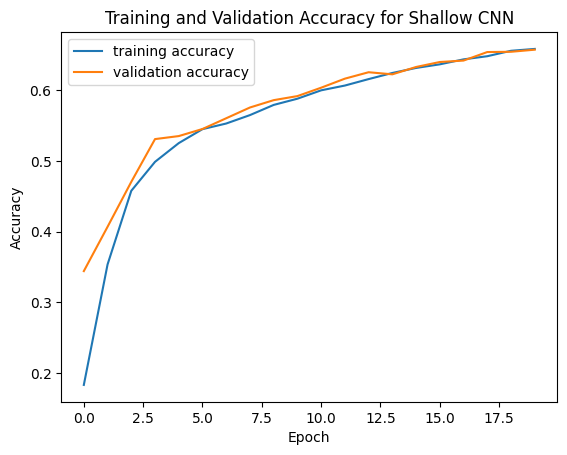

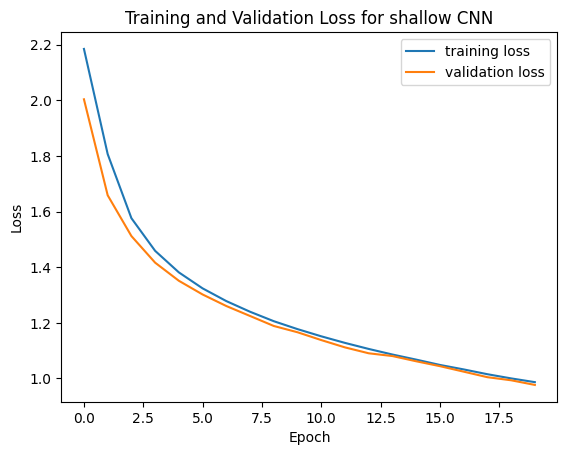

In [435]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history_shallow.history['accuracy'], label='training accuracy')
plt.plot(history_shallow.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy for Shallow CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history_shallow.history['loss'], label='training loss')
plt.plot(history_shallow.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss for shallow CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Accuracy & loss for VGG per epoch

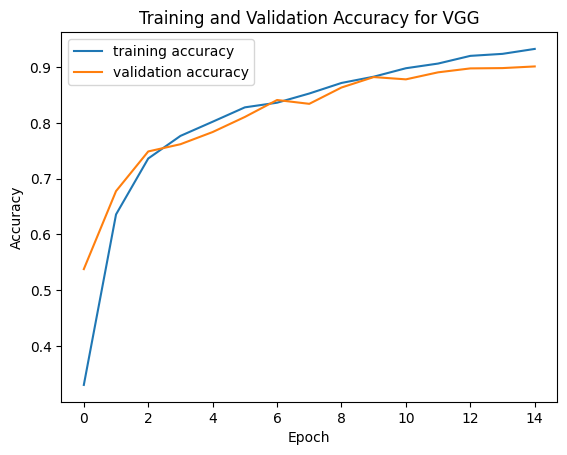

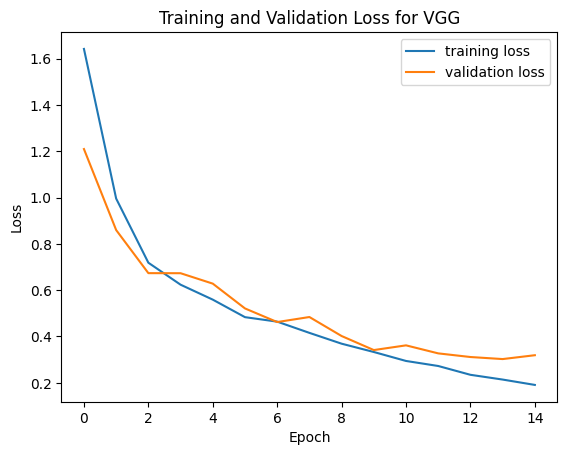

In [429]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy for VGG')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss for VGG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Evaluation: classification report and confusion matrix

In [443]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_data, verbose=0)
print(f'Validation accuracy: {accuracy:.2f}')

# Make predictions on the validation set
predictions = model.predict(val_data)


Validation accuracy: 0.90
169/169 [==============================] - 9s 50ms/step


In [444]:
# Get true classes from generator
true_classes = val_data.classes

# Get class labels from directory names
class_labels = list(val_data.class_indices.keys())

# Convert predicted classes from one-hot encoding to label encoding
predicted_classes = np.argmax(predictions, axis=1)

# Print classification report
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.88      0.90       599
              Forest       0.97      0.96      0.97       599
HerbaceousVegetation       0.81      0.90      0.85       599
             Highway       0.81      0.89      0.85       499
          Industrial       0.93      0.94      0.93       499
             Pasture       0.88      0.84      0.86       399
       PermanentCrop       0.87      0.69      0.77       499
         Residential       0.94      0.99      0.96       599
               River       0.90      0.89      0.89       499
             SeaLake       0.99      0.97      0.98       599

            accuracy                           0.90      5390
           macro avg       0.90      0.90      0.90      5390
        weighted avg       0.90      0.90      0.90      5390



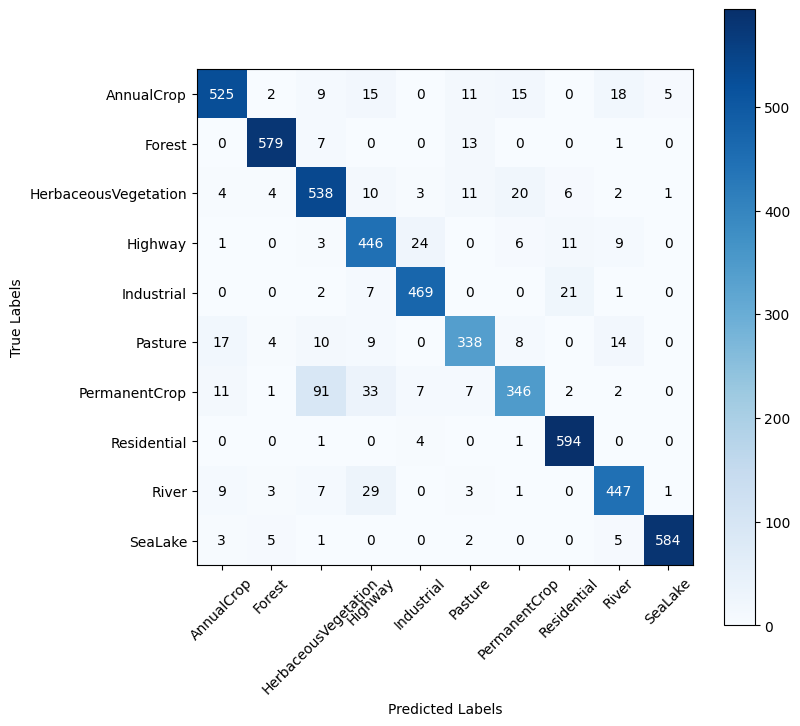

In [442]:
import sklearn.metrics as metrics

# Get the confusion matrix with raw counts
conf_mat = metrics.confusion_matrix(true_classes, predicted_classes, normalize=None)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(conf_mat, cmap=plt.cm.Blues)

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)

# Set axis labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names)

# Add annotations to each cell
thresh = conf_mat.max() / 2.0
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(j, i, format(conf_mat[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_mat[i, j] > thresh else "black")

# Show the plot
plt.show()


# Saving model

In [420]:
import datetime
from tensorflow.keras.models import model_from_json

# Define the directory where you want to save your model files
model_dir = 'saved_models/'

# Create the directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)




# Save the model architecture to a JSON file
model_json = model.to_json()
with open(os.path.join(model_dir, 'model_architecture.json'), 'w') as json_file:
    json_file.write(model_json)

# Save the model weights to an HDF5 file
model.save_weights(os.path.join(model_dir, 'model_weights.h5'))

# Save the entire model to an HDF5 file
model.save(os.path.join(model_dir, 'my_model.h5'))

# Create a README file with information about the model
readme_text = """This directory contains saved model files for my_model.

Training data: sate images with around 3000 data counts per class. There are 10 classes.
Preprocessing steps: Normalizing data and splitting 80-20 to training and validation sets.
Evaluation metrics: per-class accuracy
"""

with open(os.path.join(model_dir, 'README.md'), 'w') as readme_file:
    readme_file.write(readme_text)

# Add a timestamp to the model filename
timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
model_filename = f'my_model_{timestamp}.h5'

# Save the entire model to an HDF5 file with a timestamped filename
model.save(os.path.join(model_dir, model_filename))

# Save the class dictionary to a file
class_dict = dict((v,k) for k,v in train_data.class_indices.items())
with open('./saved_models/class_dict.txt', 'w') as file:
    for key, value in class_dict.items():
        file.write(str(key) + ':' + str(value) + '\n')



In [282]:
# Load the model architecture from the JSON file
with open(os.path.join(model_dir, 'model_architecture.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights from the HDF5 file
loaded_model.load_weights(os.path.join(model_dir, 'model_weights.h5'))

# Load the class dictionary
class_dict = {}
with open('saved_models/class_dict.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(':')
        class_dict[int(key)] = value



In [276]:
# Make predictions using the loaded model
pred =loaded_model.predict(val_data)

  7/169 [>.............................] - ETA: 1s 

2023-03-17 00:51:46.982242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - 2s 8ms/step


In [273]:
# Load and preprocess the image
image = cv2.imread('./2750/AnnualCrop/AnnualCrop_7.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (64, 64))
image = np.expand_dims(image, axis=0)

# Make a prediction on the image
predictions = loaded_model.predict(image)

# Print the predicted class probabilities
print(predictions)

1/1 [==============================] - 0s 25ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [262]:
predictions

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [263]:
# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Print the predicted class index and probability
print("Predicted class index:", predicted_class_index)
print("Predicted probability:", predictions[0][predicted_class_index])

Predicted class index: 0
Predicted probability: 1.0


In [260]:
train_data.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}